In [2]:
import numpy as np
import pandas as pd

from scipy import integrate
from scipy import special
from scipy.special import factorial, iv
from scipy.stats import uniform, chi2, expon, norm
import matplotlib.pyplot as plt

%matplotlib inline
np.set_printoptions(2)

## Generate density probability functions

CPU times: user 184 ms, sys: 3.25 ms, total: 187 ms
Wall time: 190 ms


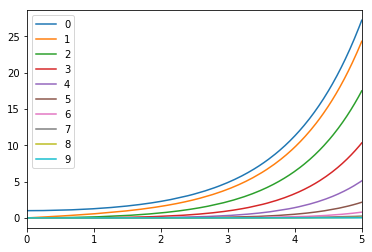

In [33]:
%%time
x_ax = np.linspace(0, 5, 1000)
n_species = 10
df_bess = pd.DataFrame([iv(k, x_ax) for k in range(n_species)]).T.round(3)
df_bess.index = x_ax

df_bess.plot()

In [34]:
# set parameters
k = 5
l = 0.8
mu = 0.5
f = 1
lambda_f = f * l 

In [9]:
def integrand(u, mu, lambda_f, k):
    exp_part = np.exp(-(mu + lambda_f) * u)
    bessel_part = iv(k, 2 * u * np.sqrt(mu * lambda_f))
    return exp_part * (k / u) * bessel_part

def survival_time(t, k, lambda_f, mu):
    integr = integrate.quad(integrand, 0, t, args=(mu, lambda_f, k))[0]
    coef_power = (mu / lambda_f)**(k / 2)
    return 1 - coef_power * integr

def survival_dens(t, k, lambda_f, mu):
    coef_power = (mu / lambda_f)**(k / 2)
    exp_part = np.exp(-(mu + lambda_f) * t)
    bessel_part = iv(k, 2 * t * np.sqrt(mu * lambda_f))
    return coef_power * exp_part * (k / t) * bessel_part

In [10]:
my_range = [2 ** i for i in range(5)]

x_ax_surv = np.linspace(1, 100, 1000)
df_surv = pd.DataFrame([[survival_time(x, k, lambda_f, mu) for k in my_range] for x in x_ax_surv])

x_ax_surv_dens = np.linspace(1, 10, 1000)
df_surv_dens = pd.DataFrame([[survival_dens(x, k, lambda_f, mu) for k in my_range] for x in x_ax_surv_dens])

In [11]:
df_surv.index = x_ax_surv
df_surv.columns = my_range
df_surv_dens.index = x_ax_surv_dens
df_surv_dens.columns = my_range

lambda_f 0.6237848179069968 mu 0.5


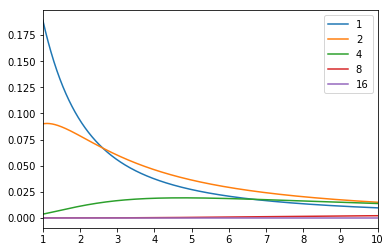

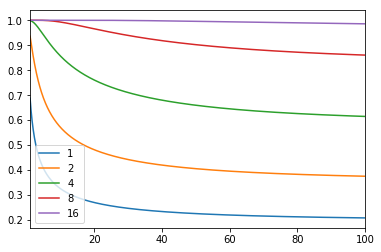

In [37]:
print('lambda_f', lambda_f, 'mu', mu)
df_surv_dens.plot();
df_surv.plot()

In [12]:
# probability of surviving forever
[round(1 - (mu/lambda_f) ** k, 3) for k in my_range]

[0.375, 0.609, 0.847, 0.977, 0.999]

In [13]:
def build_graphs(mu, lambda_f, rang=my_range):
    x_ax_surv = np.linspace(.01, 100, 1000)
    df_surv = pd.DataFrame([[survival_time(x, k, lambda_f, mu) for k in my_range] for x in x_ax_surv])
    
    x_ax_surv_dens = np.linspace(.01, 50, 1000)
    df_surv_dens = pd.DataFrame([[survival_dens(x, k, lambda_f, mu) for k in my_range] for x in x_ax_surv_dens])
    
    df_surv.index = x_ax_surv
    df_surv.columns = my_range
    df_surv_dens.index = x_ax_surv_dens
    df_surv_dens.columns = my_range
    
    return {'Survival repartition': df_surv, 'Survival density': df_surv_dens, 
            'Mu': mu, 'Lambda_f': lambda_f, 'Ratio l/mu': lambda_f/mu}

In [14]:
graphs = build_graphs(1, 0.3)

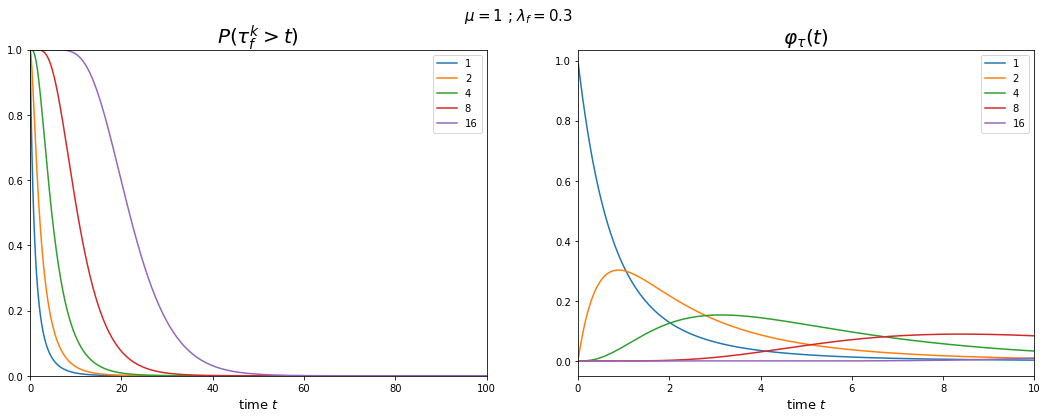

In [201]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
graphs['Survival repartition'].plot(title=r'$P(\tau_f^k > t)$', figsize=(18, 6), ax=ax1, xlim=(0, 100), ylim=(0, 1))
graphs['Survival density'].plot(title=r'$\varphi_\tau(t)$', figsize=(18, 6), ax=ax2, xlim=(0, 10))

ax1.title.set_size(20)
ax2.title.set_size(20)
ax1.set_xlabel('time $t$', fontsize=13)
ax2.set_xlabel('time $t$', fontsize=13)

st = fig.suptitle(' $\mu={}$ ; $\lambda_f={}$'.format(graphs['Mu'], graphs['Lambda_f']), fontsize=15)

In [202]:
fig.savefig('extinct (l_f 666, mu 1).png', dpi=400)

# Random walk simulation

Le lemme 3.3 de la preuve montre que notre étude peut se ramener à la simulation d'une marche aléatoire
de Bernoulli, démarrant à $k$ et avec probabilité $\lambda_f/c$ et $\mu/c$

In [17]:
%%time
np.random.seed(40)
n = 20000
k = 2
f_k = sorted(np.random.random(size=(k)))
f = f_k[-1]
print(f)

my_lambda = 5
mu = 0.5
lambda_f = my_lambda * f

for j in range(n):
    if j%3000==0:
        if f in f_k:
            print('f in fk at time {}'.format(j))
    tirage = (lambda_f+mu) * np.random.random()
    if tirage < lambda_f:
        new_spec_fitness = np.random.random()
        f_k.append(new_spec_fitness)
        f_k = sorted(f_k)
    else:
        if len(f_k) > 0:
            f_k.pop(0)
        else:
            pass

0.4076870280802861
f in fk at time 0
f in fk at time 3000
f in fk at time 6000
f in fk at time 9000
f in fk at time 12000
f in fk at time 15000
f in fk at time 18000
CPU times: user 2.37 s, sys: 43.2 ms, total: 2.41 s
Wall time: 2.44 s


In [22]:
df = pd.DataFrame({'f_val': f_k})
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
f_val,0.219194,0.241998,0.242143,0.242349,0.242355,0.24284,0.242977,0.243051,0.243074,0.243143


Text(0.5,0,'valeur sélective $\\subset Supp(F)$')

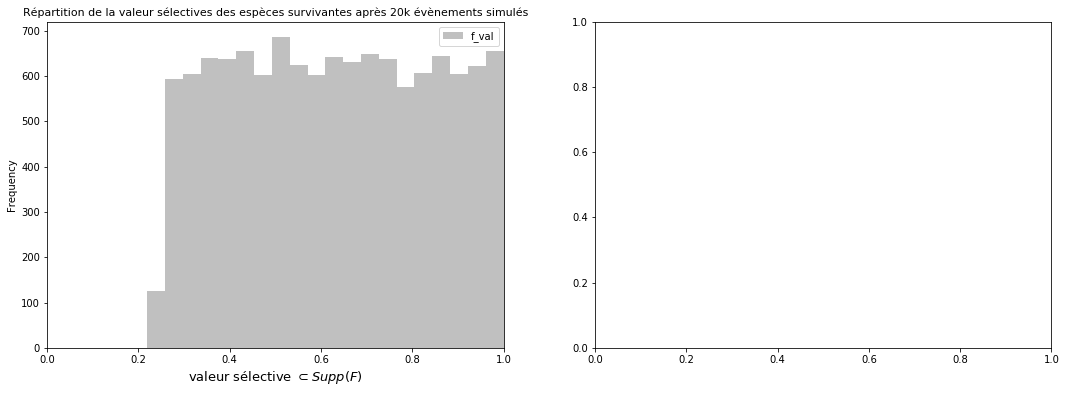

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

my_title = 'Répartition de la valeur sélectives des espèces survivantes après {}k évènements simulés'.format(n//1000)
df.plot(kind='hist', title=my_title, color='silver',
        bins=20, ax=ax1, figsize=(18, 6), xlim=(0, 1))

ax1.title.set_size(11)
ax1.set_xlabel(r'valeur sélective $\subset Supp(F)$', fontsize=13)

In [26]:
lambd=2
mu=0.4
k=5
n_simul=10000

In [27]:
def simulate_process(lambd=0.42, mu=0.4, k=5, fitness_distrib='uniform 0 1', n_simul=5, log=False):
    params = fitness_distrib.split(' ')
    
    global initial_fitnesses, proba_distrib, f_c
    try:
        proba_distrib = eval(params[0])(*[float(params[k]) for k in range(1, len(params))])
        initial_fitnesses = sorted(proba_distrib.ppf(np.random.random(k)))
    except ValueError:
        return 'not a suitable fitness distribution'
    
    if log: 
        print('k = {} \nf_1, ..., f_k = {}'.format(k, [round(x, 3) for x in initial_fitnesses]))
    
    f_c = round(proba_distrib.ppf(mu/lambd), 2)
    for _ in range(n_simul):
        sc = np.random.random()

        if sc < lambd / (lambd + mu):
            new_fitness = proba_distrib.ppf(np.random.random())
            initial_fitnesses.append(new_fitness)
            initial_fitnesses = sorted(initial_fitnesses)
            
            if log: 
                print(round(sc, 2), [round(x, 3) for x in initial_fitnesses], len(initial_fitnesses))
        else:
            if len(initial_fitnesses) > 0:
                initial_fitnesses.pop(0)
            else:
                pass
            if log: 
                print(round(sc, 2), [round(x, 3) for x in initial_fitnesses], len(initial_fitnesses))


In [32]:
distrib = 'norm 0 1'
my_lambd = 2
my_mu = 1.66

simulate_process(lambd=my_lambd, mu=my_mu, k=10, fitness_distrib=distrib, n_simul=20000)

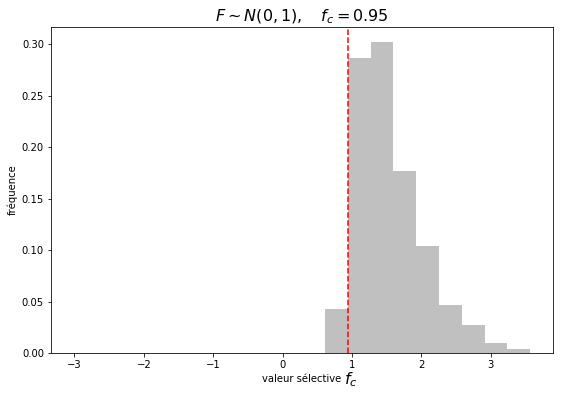

In [155]:
n_bins = 20
inter = proba_distrib.interval(0.999)
extent = inter[0] - inter[1]

my_bins = [round(f_c + (extent / n_bins) * x, 3) - 0.01 for x in range(- n_bins, n_bins + 1)]
try:
    relevant_bins_inf = [inter[0] < x < inter[1] for x in my_bins].index(True) - 1
    relevant_bins_sup = [inter[0] < x < inter[1] for x in my_bins][::-1].index(True) 

    my_bins = sorted(my_bins[relevant_bins_inf:-relevant_bins_sup])
except:
    pass

plt.figure(figsize=(9, 6))

x, y, _ = plt.hist(initial_fitnesses, 
                   weights=np.zeros_like(initial_fitnesses) + 1. / len(initial_fitnesses), 
                   bins=my_bins, 
                   color='silver')

plt.title(r'$F \sim N(0,1), \quad f_c = {}$'.format(f_c), fontsize=16)
plt.annotate(r'$f_c$', (f_c, 0), (f_c -1/100 * (max(y)-min(y)), -x.max() / 10), fontsize=16)
plt.axvline(x=f_c, color='red', linestyle='dashed', linewidth=1.5)       # show critical value
plt.xlabel('valeur sélective')
plt.ylabel('fréquence')
plt.savefig('{}.png'.format(distrib), dpi=400)
plt.show()